In [ ]:
from p_tqdm import p_umap

p_umap()

In [1]:
import numpy as np
import pandas as pd
from math import floor, sqrt

rng = np.random.default_rng(16558947)

In [ ]:
np.geom

In [2]:
class milshtein_OU_N_2D:
    #
    # OU model:
    # dX = -(1/tau)*(X - center)*dt + sqrt(g)*dW
    # dW is white noise
    #
    def __init__(self, rng, x0, tau, center, g_sqrt, h, N):
        # random number generator
        self.rng = rng
        # time-step
        self.h = h
        # number of independent 'movers'
        self.N = int(N)
        # Process parameters (all of them are numpy vectors!)
        self.tau = tau # shape = (N,2)
        self.g_sqrt = g_sqrt # shape = (N,2) 
        self.xi = x0 # shape = (N,2)
        self.center = center # shape = (N,2)

        # Auxiliary Variables
        self.h_sqrt = np.sqrt(h)
        # self.g_sqrt = np.sqrt(g)

    def __call__(self, delta_t):
        # number of time intervals to be considered
        intervals = int(np.ceil(delta_t/self.h))

        # generate all random values at once
        uh = self.h_sqrt*self.rng.normal(size=(self.N, 2, intervals))
        
        for i in range(intervals):
            self.xi += uh[:,:,i]*self.g_sqrt + self.h*(self.center - self.xi)/self.tau
        return self.xi

In [3]:
class milshtein_OU:
    def __init__(self, seed: int, x0: float, tau: float, center: float, g: float, h: float):
        from math import sqrt
        
        # Process parameters
        self.tau = tau
        self.h = h
        self.seed = seed
        self.xi = x0
        self.center = center
        self.g = g

        # Auxiliary Random Number Generators
        self.rng = np.random.default_rng(self.seed)

        # Auxiliary Variables
        self.h_sqrt = sqrt(h)
        self.g_sqrt = sqrt(g)

    def __call__(self, delta_t):
        # number of time intervals to be considered
        intervals = int(np.ceil(delta_t/self.h))

        # generate all random values at once
        uh = self.h_sqrt*self.rng.normal(size=(intervals))
        
        for i in range(intervals):
            self.xi += uh[i]*self.g_sqrt + self.h*(self.center - self.xi)/self.tau
        return self.xi


In [4]:
class agent:
    def __init__(self, pos, seed, tau, center, g, h):
        self.pos = pos
        self.mover = milshtein_OU(seed=seed, x0=pos, tau=tau, center=center, g=g, h=h)

    def distance_from(self, other):
        return sqrt((self.pos[0]-other.pos[0])*(self.pos[0]-other.pos[0]) + (self.pos[1]-other.pos[1])*(self.pos[1]-other.pos[1]))

    def OUmove(self, delta_t, env_size):
        self.pos = self.mover(delta_t=delta_t) % env_size


In [27]:
class cell_list:
    
    def __init__(self, Nagents, inter_distance, birth_rate, tau, g, centers, dispersal_kernel, data_interval=1., h=1e-3, env_size=1e2, seed=34567, rng=None, cell_width = None, n_cell_divisions = None):

        # ASSERTIONS

        # define cell list properties
        
        if (cell_width is not None) and (n_cell_divisions is not None):
            assert False, "Please set either `cell_width` or `n_cell_divisions`"
        
        elif cell_width is not None:
            assert env_size % cell_width == 0., "Please select a cell_width which is a divisor of env_size"

            self.cell_width = float(cell_width)
            self.n_cell_divisions = int(env_size / cell_width)

        elif n_cell_divisions is not None:
            assert type(n_cell_divisions) == int, "Please select an integer number of n_cell_divisions"

            self.cell_width = float(env_size / cell_width)
            self.n_cell_divisions = int(n_cell_divisions)
        
        else:
            assert False, "Please set either `cell_width` or `n_cell_divisions`"

        # ENV PROPERTIES
        
        self.env_size = env_size
        self.pos_cell_conversion = self.n_cell_divisions/self.env_size

        # SETUP CELL_LIST

        self.cell_neighborhood = {cellx: {celly: self.neighbor_cells(np.array([cellx, celly])) for celly in range(self.n_cell_divisions)}  for cellx in range(self.n_cell_divisions)}

        self.periodic_wrapping = {}
        for cellx in range(self.n_cell_divisions):
            self.periodic_wrapping[cellx] = {}
            for celly in self.cell_neighborhood[cellx]:
                self.periodic_wrapping[cellx][celly] = self.periodic_wrapping_vector(np.array([cellx, celly]), self.cell_neighborhood[cellx][celly])

            
        # SETUP RANDOM NUMBER GENERATOR
        if rng is None:
            self.ss = np.random.SeedSequence(seed)
            self.rng = np.random.default_rng(self.ss)
        else:
            self.rng = rng

        

        # Environment properties
        self.h = h
        self.t = 0.

        # Number, interactions
        self.N = Nagents
        self.birth_rate = birth_rate
        self.interaction_distance = inter_distance
        self.interaction_rate = 1./(np.pi*inter_distance*inter_distance)

        # Dispersal kernel
        # assume a gaussian dispersal kernel with stdev dispersal_kernel
        self.dispersal_kernel = dispersal_kernel


        # interaction-related
        self.possible_interacting_pairs = np.array([])
        self.n_interacting_pairs = 0.
        
        # Stochastic properties
        self.tau = tau
        self.g = g

        # Gillespie variables
        self.total_rate = 0.
        self.total_birth_rate = 0.
        self.total_interaction_rate = 0.

        # Position
        if centers == 'random':
            self.centers = self.rng.uniform(high=env_size, size=(self.N, 2))
        else:
            self.centers = centers

        # INITIALIZE AGENTS

        # self.agent_pos_index =
        self.agent_adresses = {}
        self.agents = {idx+1: agent(pos=c, seed=self.ss, tau=self.tau, center=c, g=self.g, h=self.h) for idx, c in enumerate(self.centers)}
        self.agent_next_idx = self.N +1

        self.empty_cell_index = {}
        for cellx in range(self.n_cell_divisions):
            self.empty_cell_index[cellx] = {}
            for celly in range(self.n_cell_divisions):
                self.empty_cell_index[cellx][celly] = set()

        self.cell_index = self.empty_cell_index.copy()
        self.calculate_agents_cells()

        # Stored data
        self.data = []
        self.data_interval = data_interval
        self.n_stored_data = 0

    def run(self, total_time):
        self.t = 0.
        while self.t < total_time:
            self.gillespie_step()
            if self.t > self.data_interval*self.n_stored_data:
                self.data.append(self.store_data())
                print(f"N = {self.N} | time: {self.t:.0e} = {self.t/total_time:.1%}")
                self.n_stored_data += 1
        print("Job's done!")
        

    def gillespie_step(self):
        # calculate all possible interaction rates
        self.calculate_rates()

        # calculate residence time
        delta_t = rng.exponential(scale=1/self.total_rate)

        # choose process
        probabilites = np.array([self.total_birth_rate, self.total_interaction_rate])
        probabilites = probabilites/(probabilites[0] + probabilites[1])
        isbirth = rng.choice([True, False], p=probabilites)

        # implement birth
        if isbirth:
            # choose randomly which individual gave birth
            repr_id = rng.choice(list(self.agents.keys()))
            # update birth
            self.update_birth(repr_id=repr_id)

        # implement interaction (death)
        else:
            # choose randomly which pair interacted
            interacting_pair = self.possible_interacting_pairs[rng.integers(self.n_interacting_pairs)]
            # choose randomly which individual of the pair died
            dead_id = rng.choice(interacting_pair)
            # update death
            self.update_death(dead_id=dead_id)

        # move everyone
        self.move(delta_t=delta_t)

        # update time
        self.t += delta_t

    def calculate_rates(self):
        # total birth rate
        self.total_birth_rate = self.birth_rate * self.N

        # total interaction rate
        self.calc_interaction_pairs()
        self.total_interaction_rate = self.interaction_rate * self.n_interacting_pairs

        # total rate
        self.total_rate = self.total_interaction_rate + self.total_birth_rate

    def calc_interaction_pairs(self):
        '''
        function to calculate the possible interaction pairs using cell stuff
        '''
        #++ check whether agent ids are guaranteed to be sorted
        #++ check whether sorting agents and imposing interacting agents have higher id (\sum_{i,j>i}) is faster then using sets
        calculated_sets = set()
        interaction_pairs = []
        tot_int = 0
        for ag_id in self.agents:
            cx, cy = self.agent_adresses[ag_id]
            possible_pairs = self.cell_index[cx][cy].copy()
            for cellx, celly in self.neighbor_cells([cx, cy]):
                possible_pairs.update(self.cell_index[cellx][celly])
            
            possible_pairs.difference_update(calculated_sets)
            # BUG I am not considering the periodic distances!
            for other_id in possible_pairs:
                if self.agents[ag_id].distance_from(self.agents[other_id]) < self.interaction_distance:
                    interaction_pairs.append([ag_id, other_id])
                    tot_int += 1

            calculated_sets.add(ag_id)
            
        self.possible_interacting_pairs = np.array(interaction_pairs)
        self.n_interacting_pairs = tot_int

    def update_birth(self, repr_id):
        # disperse center of new individual
        new_center = rng.normal(loc=self.agents[repr_id].pos, scale=self.dispersal_kernel, size=2)
        new_center = new_center%self.env_size

        # add new agent
        # TODO: agents are starting at their new center
        self.agents[self.agent_next_idx] = agent(pos=new_center, center=new_center, seed=self.ss, tau=self.tau, g=self.g, h=self.h)
        self.N += 1

        # update the indexes
        cx, cy = self.calculate_agent_cell(self.agent_next_idx)
        self.cell_index[cx][cy].add(self.agent_next_idx)
        self.agent_adresses[self.agent_next_idx] = np.array([cx, cy])
        self.agent_next_idx += 1

    def update_death(self, dead_id):
        # update the indexes
        cx, cy = self.calculate_agent_cell(dead_id)
        self.cell_index[cx][cy].remove(dead_id)
        del self.agent_adresses[dead_id]

        # remove agent
        del self.agents[dead_id]
        self.N -= 1

    def store_data(self):
        return {'t': self.t, 'N': self.N}

    def move(self, delta_t):
        for ag_id in self.agents:
            self.agents[ag_id].OUmove(delta_t=delta_t, env_size=self.env_size)
        self.calculate_agents_cells()

    def calculate_agent_cell(self, id):
        x, y = self.agents[id].pos.copy()
        return floor(x/self.pos_cell_conversion), floor(y/self.pos_cell_conversion)

    def calculate_agents_cells(self):
        for cx in self.cell_index.keys():
            for cy in self.cell_index[cx].keys():
                self.cell_index[cx][cy].clear()
        for id in self.agents:
            cx, cy = self.calculate_agent_cell(id)
            self.cell_index[cx][cy].add(id)
            self.agent_adresses[id] = np.array([cx, cy])

    def neighbor_cells(self, cell_id):
        """A function to calculate all the 

        Args:
            cell_id (int): the index identifying the cell for which the neighbors are to be found

        Returns:
            np.array(int): list of the neighboring cells to the E, NE, N, NW, W, SW, S, SE (in this order)
        """
        L = self.n_cell_divisions

        # assert 0 <= cell_id, "cell_id must be a positive integer or zero"
        # assert cell_id < L*L, "cell_id must be smaller than L^2"

        cellx, celly = cell_id

        # cell in first row
        test_S = (celly == 0)
        # cell in first column
        test_W = (cellx == 0)
        # cell in last row
        test_N = (celly == L - 1)
        # cell in last column
        test_E = (cellx == L - 1)

        # The cells can be in one of 9 classes of cells:
        #
        # NW | N | NE
        # -- | - | --
        # W  | O | E
        # -- | - | --
        # SW | S | SE             
        # 

        shift_E = np.array([[-L,0], [-L,0], [0,0], [0,0], [0,0], [0,0], [0,0], [-L,0]])
        shift_N = np.array([[0,0], [0,-L], [0,-L], [0,-L], [0,0], [0,0], [0,0], [0,0]])
        shift_W = np.array([[0,0], [0,0], [0,0], [L,0], [L,0], [L,0], [0,0], [0,0]])
        shift_S = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,L], [0,L], [0,L]])

        shift_O = np.array([[cellx+1, celly],[cellx+1, celly+1], [cellx, celly+1], [cellx-1, celly+1], [cellx-1, celly], [cellx-1, celly-1], [cellx, celly-1], [cellx+1, celly-1]])

        return shift_O + test_E*shift_E + test_N*shift_N + test_W*shift_W + test_S*shift_S

    def periodic_wrapping_vector(self, focal_cell, neighbor_cell):
        """
        I'M ASSUMING THE CELLS TO BE NEIGHBORS
        """
        L = self.n_cell_divisions - 1

        coefficient = (focal_cell - neighbor_cell)/L
        test_coef = (np.abs(coefficient) == 1.)
        if np.all(~test_coef):
            # no need for periodic vector
            return coefficient

        displacement_vec = np.array([self.env_size, self.env_size])

        return displacement_vec*test_coef*coefficient


    def find_neighbors(self):
        pass

In [28]:
env = cell_list(2000, 1., .2, .3, .4, centers='random', dispersal_kernel=2., cell_width=1.)

In [2]:
import pandas as pd

In [82]:
d = pd.read_pickle('results.zip')

In [23]:
a = pd.read_pickle('results.zip')

In [38]:
c = pd.read_pickle('results.zip')
c = pd.DataFrame(c[0][0])

In [97]:
u = np.load('t=0.001_disp=0.1_rep=0.npy')

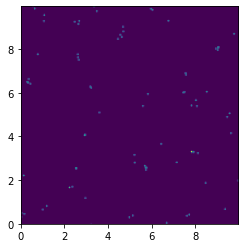

In [165]:
import matplotlib.pyplot as plt
import numpy as np


def asympt_distr(x, y, centers, stdev):
    """The idea is to calculate the cumulative probability density of an individual occuppying some spot

    Args:
        x (_type_): _description_
        y (_type_): _description_
        centers (_type_): _description_
        stdev (_type_): _description_

    Returns:
        _type_: _description_
    """
    point_vec = np.array([x,y])
    normal_dis = point_vec - centers
    normal_dis = -np.sum(normal_dis*normal_dis, axis=1)/(2*stdev*stdev)
    normal_dis = np.exp(normal_dis)
    normal_dis = normal_dis/(stdev*np.sqrt(2.*np.pi))
    return np.sum(normal_dis)


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

x = np.arange(0., 10.0, dx)
y = np.arange(0., 10.0, dy)
X, Y = np.meshgrid(x, y)

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

nx, ny = X.shape

Z = np.zeros((nx,ny))

centers = u
g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)

for i in range(nx):
    for j in range(ny):
        Z[i,j] = asympt_distr(X[i,j], Y[i,j], centers=centers, stdev=stdev)

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=False)

im = plt.imshow(Z, cmap=plt.cm.viridis, interpolation='bilinear',
                 extent=extent)

plt.show()

In [220]:
a = pd.read_pickle("results.zip")
# ls = []
# for id, it in a.iterrows():
#     ls.append(it[0])

# a = pd.DataFrame(ls)
a

,t,N,rep,tau,inter,interRate,birthRate,births,deaths
0,0.4,100,1,0.001,0.001,0.0,0.0,0,0
1,0.8,100,1,0.001,0.001,0.0,0.0,0,0
2,1.2,100,1,0.001,0.001,0.0,0.0,0,0
3,1.6,100,1,0.001,0.001,0.0,0.0,0,0
4,2.4,100,1,0.001,0.001,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
996,498.4,100,1,1000.000,10.000,0.0,0.0,0,0
997,498.8,100,1,1000.000,10.000,0.0,0.0,0,0
998,499.2,100,1,1000.000,10.000,0.0,0.0,0,0
999,499.6,100,1,1000.000,10.000,0.0,0.0,0,0


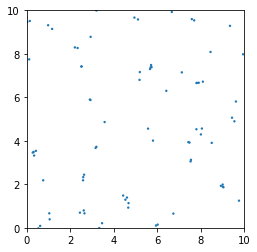

In [198]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()

centers = u

# periodic boundary conditions:
#++ this is multiplying the number of points by 9
# use the cell_list code to make only the copies that are needed
# for delta in [[10,10], [10, 0], [10, -10], [0, 10], [0, -10], [-10, 10], [-10, 0], [-10, -10]]:
#     centers = np.vstack([centers, centers + np.array(delta)])

g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)
k = np.sqrt(-np.log(1-0.95))
rho = np.sqrt(g*tau)*k

for cx, cy in centers:
    c = plt.Circle((cx, cy), radius=(rho))
    ax.add_artist(c)

ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

ax.set_aspect('equal', adjustable='box')
# plt.show()

<AxesSubplot:>

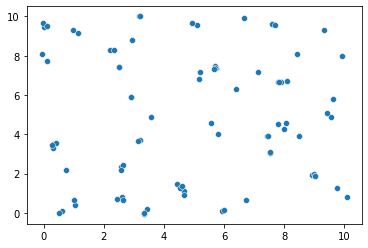

In [ ]:
sns.scatterplot(x=u.T[0], y=u.T[1])

<AxesSubplot:xlabel='N', ylabel='N'>

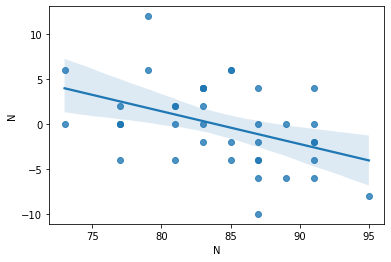

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# ax = plt.gca()
# ax.plot(d['N'].shift(1), d['N'].diff(), 'o')
sns.regplot(x=d['N'].shift(1)[-40:], y=d['N'].diff()[-40:])

In [39]:
c

,t,N,rep,tau,disp,interRate,birthRate,births,deaths
0,0.004560,101,0,0.001,0.1,38.197186,100.0,1,0
1,1.002487,133,0,0.001,0.1,128.597194,134.0,139,106
2,2.002191,149,0,0.001,0.1,162.974662,150.0,305,256
3,3.000530,137,0,0.001,0.1,140.056350,138.0,445,408
4,4.002870,142,0,0.001,0.1,145.149308,143.0,598,556
...,...,...,...,...,...,...,...,...,...
96,96.003341,87,0,0.001,0.1,82.760570,88.0,10866,10879
97,97.015930,77,0,0.001,0.1,61.115498,76.0,10939,10962
98,98.000312,84,0,0.001,0.1,82.760570,85.0,11022,11038
99,99.001048,82,0,0.001,0.1,85.307049,83.0,11101,11119


In [85]:
ls = []
for id, it in d.T.iterrows():
    ls.append(it[0])

In [87]:
d = pd.DataFrame(ls)
d

,t,N,rep,tau,disp,interRate,birthRate,births,deaths
0,0.004560,101,0,0.001,0.1,38.197186,100.0,1,0
1,0.121464,107,0,0.001,0.1,58.569019,106.0,14,7
2,0.197886,113,0,0.001,0.1,73.847894,114.0,27,14
3,0.303838,115,0,0.001,0.1,66.208456,114.0,38,23
4,0.419378,121,0,0.001,0.1,91.673247,120.0,51,30
...,...,...,...,...,...,...,...,...,...
1114,99.433511,73,0,0.001,0.1,52.202821,72.0,11127,11154
1115,99.564862,73,0,0.001,0.1,59.842259,74.0,11137,11164
1116,99.713965,79,0,0.001,0.1,82.760570,80.0,11150,11171
1117,99.797557,91,0,0.001,0.1,117.138038,90.0,11166,11175


In [33]:
891.267681/127.323954	

7.000000023561945

In [30]:
b = pd.DataFrame(ls)
b

,t,N,rep,tau,disp,interRate,birthRate,births,deaths
0,0.006302,101,0,0.001,0.1,0.000000,100.0,1,0
1,1.012375,153,0,0.001,0.1,0.000000,152.0,129,76
2,2.000894,200,0,0.001,0.1,0.000000,199.0,300,200
3,3.006054,251,0,0.001,0.1,127.323954,250.0,546,395
4,4.000697,311,0,0.001,0.1,127.323954,310.0,842,631
...,...,...,...,...,...,...,...,...,...
96,96.000584,1327,0,0.001,0.1,509.295818,1326.0,114734,113507
97,97.000132,1314,0,0.001,0.1,1655.211408,1315.0,116025,114811
98,98.000110,1358,0,0.001,0.1,891.267681,1357.0,117369,116111
99,99.000256,1320,0,0.001,0.1,763.943727,1319.0,118710,117490


In [31]:
env = cell_list(Nagents=5000, inter_distance=1., birth_rate=.2, tau=.1, g=.25, centers='random', dispersal_kernel=2., cell_width=1.)
env.run(20.)

N = 4999 | time: 1e-04 = 0.0%


KeyboardInterrupt: 

In [114]:
def periodic_wrapping_vector(n_cell_divisions, focal_cell, neighbor_cell, side_length=10.):
    '''
    ASSUMING THAT THE TWO CELLS ARE NEIGHBORS
    '''

    if all(focal_cell == neighbor_cell):
        # no need for periodic vector
        return False
        
    largest_index = n_cell_divisions - 1

    coefficient = (focal_cell - neighbor_cell)/largest_index
    # if the focal_cell and neighbor_cell are distant exactly largest_index, they are in opposite sides of the square, but adjacent in the torus
    test_coef = np.logical_or((np.abs(coefficient) == 1.), (np.abs(coefficient) == 0.))
    # test_coef is true if the cells are in opposite sides of the matrix or in the same row/column 

    # if cells are *not* in opposite sides or in the same row/column for one of the dimensions, return
    if any(~test_coef):
        # no need for periodic vector
        return False

    displacement_vec = np.array([side_length, side_length])

    return displacement_vec*coefficient

In [113]:
a = 

a
# focal = np.array([1,9])
# neigh = np.array([0,0])
# periodic_wrapping_vector(10, focal, neigh)

{1: array([ 0., 10.])}

In [102]:
focal = np.array([1,9])
neigh = np.array([0,0])
periodic_wrapping_vector(10, focal, neigh)

In [9]:
from math import sqrt
from numba import types, njit
from numba.typed import Dict


aux = Dict.empty(
    key_type=types.int64,
    value_type=types.float64[:],
)

for i in range(1000):
    aux[i] = rng.random(size=2)

@njit
def calc_distances(dic, keys):
    res = []
    for i in keys:
        for j in range(i):
            a = dic[i] - dic[j]
            b = a*a
            res.append(sqrt(b[0] + b[1]))
    return res

In [23]:
from numba import cuda

@cuda.jit
def calc_cuda_distances(dic, keys, res):
    for i in keys:
        for j in range(i):
            a = dic[i] - dic[j]
            b = a*a
            res[i,j] = (sqrt(b[0] + b[1]))
    return res

threadsperblock = (16, 16) # Should be a multiple of 32 if possible.
blockspergrid = (256, 256) # Blocks per grid
res = np.zeros(shape=(1000,1000))

In [29]:
@cuda.jit
def an_empty_kernel():
    """A kernel that doesn't do anything."""
    # Get my current position in the global grid
    [pos_x, pos_y] = cuda.grid(2)

In [32]:
threadsperblock = (16, 16) # Should be a multiple of 32 if possible.
blockspergrid = (256, 256) # Blocks per grid

In [31]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1050 Ti'                              [SUPPORTED]
                      Compute Capability: 6.1
                           PCI Device ID: 0
                              PCI Bus ID: 5
                                    UUID: GPU-315862d5-2993-40e5-6426-2d995a0c6c37
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [21]:
%%timeit
calc_distances(aux, list(range(1000)))

/home/rafael/mambaforge-pypy3/envs/msc/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'keys' of function 'calc_distances'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../../../tmp/ipykernel_598484/2752743624.py", line 14:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


68.4 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
from scipy.spatial import distance_matrix

In [18]:
aux = rng.random(size=(1000,2))

In [19]:
%%timeit
distance_matrix(aux, aux)

29.1 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import numpy as np
from numba import njit
from numba import types
from numba.typed import Dict

# First create a dictionary using Dict.empty()
# Specify the data types for both key and value pairs

# Dict with key as strings and values of type float array
dict_param1 = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:],
)

# Dict with keys as string and values of type float
dict_param2 = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)

# Type-expressions are currently not supported inside jit functions.
float_array = types.float64[:]

@njit
def add_values(d_param1, d_param2):
    # Make a result dictionary to store results
    # Dict with keys as string and values of type float array
    result_dict = Dict.empty(
        key_type=types.unicode_type,
        value_type=float_array,
    )

    for key in d_param1.keys():
      result_dict[key] = d_param1[key] + d_param2[key]

    return result_dict

dict_param1["hello"]  = np.asarray([1.5, 2.5, 3.5], dtype='f8')
dict_param1["world"]  = np.asarray([10.5, 20.5, 30.5], dtype='f8')

dict_param2["hello"]  = 1.5
dict_param2["world"]  = 10

final_dict = add_values(dict_param1, dict_param2)

print(final_dict)
# Output : {hello: [3. 4. 5.], world: [20.5 30.5 40.5]}

{hello: [3. 4. 5.], world: [20.5 30.5 40.5]}
